**ToDo**



[ ] create helper functions
- start by creating functions to view images
- fix preprocessing into functions (done)


[ ] one hot encoding (Jan 11th)
- do I need to onehot encode my classes even though there are only two classes?

**Notes**

- When intializing model parameters (model weights), it's best to initialize  randomly.

Reason: If you were to intitialze the weights using np.zeros (with zeros), then it results in the model failing to break symmetry. Which means that every neuron in each layer is learning the same thing. Basically if the weights are zero then you're multiplying by a zero vector.

Outcome: Initilize weights randomly this way each neuron learns a different function of its input. You can initialize the bias vector with zeros.




- When itializing weights it's better to initialize with small numbers than large numbers

Reason: It slows down optimization and can lead to vanishing/exploding gradients

Outcome: When you have a ReLU function, HE initialization works best

Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import flax
from flax import linen as nn #Linen API

import tensorflow_datasets as tfds
import tensorflow as tf



## Loading and Preprocessing Datasets

In [3]:
def get_datasets(split, batch_size):
  ''' loading in the dataset'''
  dataset, ds_info = tfds.load(name='horses_or_humans', split=split, with_info=True)

  def _preprocess(dataset):
    ''' preprocessing the data '''
    image = dataset["image"]
    image = tf.image.resize(image, (224,224)) #resizing the image to a common size
    image = tf.cast(image, tf.float32)  #normalizes the pixel values of the images to the range [0,1]
    label = dataset["label"]

    return {'image': image, 'label':label}

  dataset = dataset.map(_preprocess) # applying the preprocessing function to each sample in the dataset
  dataset = dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE) #prefetch next sample(s) to improve latency using TF to automatically determine optimal # of samples to prefetch

  return dataset, ds_info

##Exploring tfds

In [4]:
practice_ds, practice_info = get_datasets('train', 64)
#print(len(practice_ds)) #17 examples per batch (total of 1027 images using 64 batch size)

In [5]:
num_training_ex = practice_info.splits['train'].num_examples
num_testing_ex = practice_info.splits['test'].num_examples

print(f"The number of training examples: {num_training_ex}")
print(f"The number of testing examples: {num_testing_ex}")

The number of training examples: 1027
The number of testing examples: 256


In [6]:
practice_info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_dir='/root/tensorflow_datasets/horses_or_humans/3.0.0',
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
)

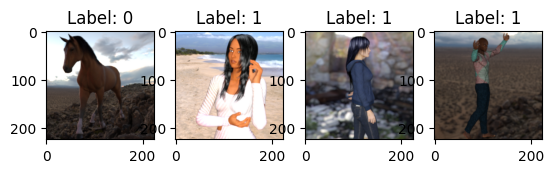

In [41]:
#@title displaying images from training set

num_images_to_display = 4

for idx, raw_image in enumerate(practice_ds.take(num_images_to_display)):
  image = raw_image['image'].numpy().astype("uint8")# .numpy() is used to convert image tensor to NumPy array then specifically cast as 'uint8'
  label = raw_image['label'].numpy().astype("uint8")
  label = int(label[0])

  if len(image.shape) == 4: #checking for batched datasets
    image = image[0] #if batched then select firs element in the batch to display

  plt.subplot(1, num_images_to_display, idx + 1)
  plt.imshow(image)
  plt.title(f"Label: {label}")


plt.show()

## Model

## Defining the model

Because this is an image classification problem, I'm choosing to start with a simple CNN model

For my first model, I'm choosing to define the submodules/variables explicitly by using the setup method but we can also define this in-line using the nn.compact method.



In [5]:
class CNN(nn.Module):
  """ A simple CNN model using setup method """
  hidden_dim: int = 64 # arbitrarily chose 64

  def setup(self):
    self.conv1 = nn.Conv(features=self.hidden_dim, kernel_size=(3,3))
    self.pool1 = nn.max_pool
    self.conv2 = nn.Conv(features=self.hidden_dim *2, kernel_size=(3,3))
    self.pool2 = nn.max_pool
    self.dense1 = nn.Dense(features=128)
    self.dense2 = nn.Dense(features=2)

  #forward pass
  def __call__(self, x):
    x = self.conv1(x)
    x = nn.relu(x)
    x = self.pool1(x, window_shape=(2,2))
    x = self.conv2(x)
    x = nn.relu(x)
    x = self.pool2(x, window_shape=(2,2))
    x = x.reshape((x.shape[0], -1)) #flattened to prepare for dense layer or (x, _ = ravel_pytree(x) flatten using JAX's ravel_pytree)
    x = self.dense1(x)
    x = nn.relu(x)
    return self.dense2(x)

model = CNN()



## Training


In [6]:
!pip install tensorboardX
#!pip install optax

In [7]:
#imports

from typing import Tuple
from flax.training import train_state
from flax import serialization
from tensorboardX import SummaryWriter
import optax

In [8]:
#creating a trains_state dictionary

train_state = {
    'epoch': 0,
    'optimizer': None,
    'model': None,
    'log_dir': 'content/logs'
}

summary_writer = SummaryWriter(train_state['log_dir'])

In [9]:
#@title Training Loop

def train_step(model: CNN, batch: dict, optimizer:optax.GradientTransformation) -> Tuple[optax.GradientTransformation, jnp.ndarray]:
  '''
  update models parameters based on the computed gradients
  '''
  def loss_function(params):
    logits = model.apply({'params':params}, batch['image']) #compute the raw output from the input images (before softmax fn is applied/ unnormalized scores/ not probabilities)
    loss = cross_entropy_loss(logits, batch['label'])
    return loss, logits

  grad_fn = jax.value_and_grad(loss_function) #computes both the value of loss function and gradient of loss
  loss, grads = grad_fn(optimizer.target) #optimizer.target keeps track of most recent set of parameters and thats passed to the grad_function
  optimizer = optimizer.apply_gradient(grads) # this is the updating parameters step using computed gradients

  return optimizer, loss

def train_epoch(model,train_dataset, optimizer, summary_writer, epoch):
  num_batches = len(training_dataset)
  total_loss = 0.0
  total_accuracy = 0.0

  for batch in train_dataset:
    optimizer, loss = train_step(model, optimizer)
    total_loss += loss
    total_accuracy += accuracy(model.apply(optimizer.target, batch['image']), batch['label'])

  mean_loss = total_loss / num_batches
  mean_accuracy = total_accuracy / num_batches

  #logging metrics to tensorboard
  summary_writer.add_scalar('train_loss', mean_loss, epoch)
  summary_writer.add_scalar('train_accuracy', mean_accuracy, epoch)

  return optimizer, mean_loss, mean_accuracy

def train_model(model, train_dataset,num_epochs=10, learning_rate= 1e-3):
  optimizer = optax.adam(learning_rate).init(model.init(jax.random.PRNGKey(0), jax.random.normal(jax.random.PRNGKey(0), (1,224,244,3)))) #initalizes Adam optimizer with the initial set of model parameters using model.init
  train_state['optimizer'] = optimizer #setting optimizer in the train_state dictionary
  train_state['model'] = model #setting model in train_state dictionary

  for epoch in range(train_state['epoch'], train_state['epoch'] + num_epochs):
    optimizer, train_loss, train_accuracy = train_epoch(model, train_dataset, optimizer, summary_writer, epoch)
    print(f"Epoch {epoch +1}/{train_state['epoch'] + num_epochs}, Loss:{train_loss}, Accuracy: {train_accuracy}")

    # Save model checkpoint
    flax.serialization.save_checkpoint(train_state['model'], train_state['optimizer'], f'./checkpoints/model_checkpoint_{epoch}.ckpt')

  train_state['epoch'] += num_epochs #updates training state
  return model, optimizer

## Run

In [ ]:
#load the datasets
#train_dataset = load_dataset('train', batch_size = 32)

In [10]:
model = CNN() #creating the model

In [11]:
#train the model

train_model, optimizer = train_model(model,practice_ds,num_epochs=10, learning_rate=1e-3)

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 8802140416 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:        16B
              constant allocation:         0B
        maybe_live_out allocation:    3.28GiB
     preallocated temp allocation:    8.20GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:   11.48GiB
              total fragmentation:    1.64GiB (14.29%)
Peak buffers:
	Buffer 1:
		Size: 3.28GiB
		Operator: op_name="jit(_truncated_normal)/jit(main)/jit(clip)/min" source_file="/usr/local/lib/python3.10/dist-packages/flax/core/scope.py" source_line=979
		XLA Label: fusion
		Shape: f32[6876672,128]
		==========================

	Buffer 2:
		Size: 1.64GiB
		Operator: op_name="jit(_truncated_normal)/jit(main)/jit(_uniform)/threefry2x32" source_file="/usr/local/lib/python3.10/dist-packages/flax/core/scope.py" source_line=979
		XLA Label: custom-call
		Shape: u32[440107008]
		==========================

	Buffer 3:
		Size: 1.64GiB
		Operator: op_name="jit(_truncated_normal)/jit(main)/jit(_uniform)/threefry2x32" source_file="/usr/local/lib/python3.10/dist-packages/flax/core/scope.py" source_line=979
		XLA Label: custom-call
		Shape: u32[440107008]
		==========================

	Buffer 4:
		Size: 1.64GiB
		Operator: op_name="jit(_truncated_normal)/jit(main)/jit(_uniform)/slice[start_indices=(440107008,) limit_indices=(880214016,) strides=None]" source_file="/usr/local/lib/python3.10/dist-packages/flax/core/scope.py" source_line=979
		XLA Label: fusion
		Shape: u32[440107008]
		==========================

	Buffer 5:
		Size: 1.64GiB
		Operator: op_name="jit(_truncated_normal)/jit(main)/jit(_uniform)/slice[start_indices=(0,) limit_indices=(440107008,) strides=None]" source_file="/usr/local/lib/python3.10/dist-packages/flax/core/scope.py" source_line=979
		XLA Label: fusion
		Shape: u32[440107008]
		==========================

	Buffer 6:
		Size: 1.64GiB
		Operator: op_name="jit(_truncated_normal)/jit(main)/jit(_uniform)/threefry2x32" source_file="/usr/local/lib/python3.10/dist-packages/flax/core/scope.py" source_line=979
		XLA Label: fusion
		Shape: u32[440107008]
		==========================

	Buffer 7:
		Size: 16B
		Operator: op_name="jit(_truncated_normal)/jit(main)/jit(_uniform)/threefry2x32" source_file="/usr/local/lib/python3.10/dist-packages/flax/core/scope.py" source_line=979
		XLA Label: fusion
		Shape: (u32[440107008], u32[440107008])
		==========================

	Buffer 8:
		Size: 16B
		Operator: op_name="jit(_truncated_normal)/jit(main)/jit(_uniform)/threefry2x32" source_file="/usr/local/lib/python3.10/dist-packages/flax/core/scope.py" source_line=979
		XLA Label: custom-call
		Shape: (u32[440107008], u32[440107008])
		==========================

	Buffer 9:
		Size: 8B
		Entry Parameter Subshape: u32[2]
		==========================

	Buffer 10:
		Size: 4B
		Entry Parameter Subshape: s32[]
		==========================

	Buffer 11:
		Size: 4B
		Entry Parameter Subshape: s32[]
		==========================



In [ ]:
#evaluate model
#evaluate(trained_model, eval_dataset)

In [ ]:
# Close the TensorBoard writer
#summary_writer.close()